Hay una formula a seguir a la hora de juntar jugadores para que formen una pareja de padel?

El objetivo del trabajo es agrupar, mediante un modelo de machine learning no supervisado, a los jugadores de padel, segun ciertas caracteristicas, y asi empezar a evaluar cuáles son las mejores combinaciones que se pueden realizar al conformar una pareja y, también, cuáles son malas combinaciones... estadisticamente hablando.

In [57]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import statsmodels.api as sm

In [58]:
df_data = pd.read_excel("_ml_jug.xlsx")

Análisis del dataset

In [59]:
df_data.shape

(1192, 26)

In [60]:
df_data.columns

Index(['nombre', 'edad', 'alt', 'pos', 'torneo', 'set', 'saque', 'NF_total',
       'w_total', 'sm_total', 'nsmtotal', 'prec sm%', 'csm', 'fondo', 'm3',
       'm5', 'm7', 'pts_ganados', 'games_jug', 'circuito', 'fase', 'mano',
       'spcsm', 'bloc', 'partido', 'nfr'],
      dtype='object')

In [61]:
round(df_data.describe(),2)

,edad,alt,saque,NF_total,w_total,sm_total,nsmtotal,prec sm%,csm,fondo,m3,m5,m7,pts_ganados,games_jug,spcsm,bloc,nfr
count,1192.00,1192.00,1192.0,1192.00,1192.00,1192.00,1192.00,886.00,1192.00,1192.00,1192.00,1192.00,1192.00,1192.00,1192.00,488.00,488.00,144.00
mean,27.15,1.81,1.5,2.02,3.42,1.59,0.84,64.75,0.35,0.25,1.04,1.72,3.71,6.47,4.71,0.45,0.16,1.56
std,6.06,0.05,0.5,1.57,2.41,1.76,1.15,34.08,0.68,0.53,1.22,1.55,2.29,3.37,0.89,0.72,0.49,1.43
min,18.00,1.67,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
25%,23.00,1.75,1.0,1.00,2.00,0.00,0.00,50.00,0.00,0.00,0.00,1.00,2.00,4.00,4.00,0.00,0.00,0.00
50%,26.00,1.80,1.5,2.00,3.00,1.00,0.00,67.00,0.00,0.00,1.00,1.00,3.00,6.00,5.00,0.00,0.00,1.00
75%,29.00,1.85,2.0,3.00,5.00,2.00,1.00,100.00,1.00,0.00,2.00,3.00,5.00,9.00,5.00,1.00,0.00,3.00
max,47.00,1.90,2.0,9.00,13.00,9.00,7.00,100.00,6.00,3.00,9.00,9.00,15.00,17.00,6.00,3.00,3.00,6.00


In [62]:
df_data.isna().sum()

nombre            0
edad              0
alt               0
pos               0
torneo            0
set               0
saque             0
NF_total          0
w_total           0
sm_total          0
nsmtotal          0
prec sm%        306
csm               0
fondo             0
m3                0
m5                0
m7                0
pts_ganados       0
games_jug         0
circuito          0
fase              0
mano              0
spcsm           704
bloc            704
partido         704
nfr            1048
dtype: int64

Hay valores NaN en prec sm% - esto seria la efectividad de los remates, pero como hay jugadores que no rematan en un set, para no computar un 0 en su promedio, se lo deja como Nan. Al hacer la media total de cada caracteristica, este valor va a dejar de ser Nan porque todos los jugadores remataron al menos una vez
Las ultimas 4 caracteristicas van a ser borradas del df ya que no hay de todos los jugadores, y no son importantes

Aprendizaje no supervisado - KMEANS

In [63]:
model = KMeans(n_clusters=3, random_state= 43)

Se va a crear un df dividiendo las caracteristicas por la cantidad de games jugados.
Se eligieron las 3 columnas mas relevantes al analizar partidos, como son los puntos por game (pxg), errores no forzados por game (nfxg) y remates por game (rem)

In [64]:
cc = pd.DataFrame()
cc = cc.assign(name = df_data["nombre"])
cc = cc.assign(pxg = df_data["pts_ganados"]/df_data['games_jug'])
cc = cc.assign(nfxg = df_data["NF_total"]/df_data['games_jug'])
cc = cc.assign(rem = (df_data["sm_total"] + df_data["nsmtotal"])/df_data['games_jug'])

cc = cc.groupby("name")[["pxg","nfxg","rem"]].mean().sort_values(by="pxg", ascending=False)

c_index = cc.index
cc.reset_index(inplace =True, drop=True)

cc1 = cc
cc = cc.values

C:\Users\UsuarioW10\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Inercia')

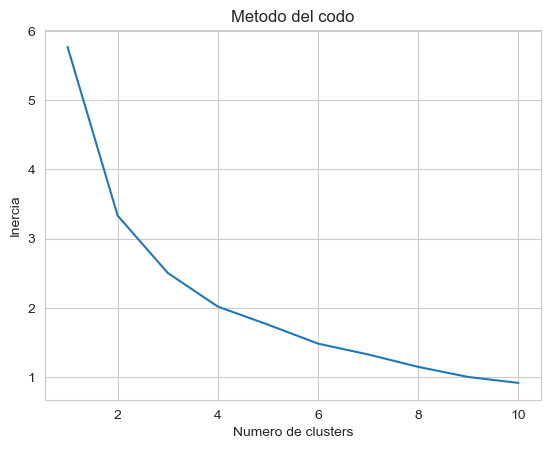

In [65]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(cc)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Metodo del codo')
plt.xlabel('Numero de clusters')
plt.ylabel('Inercia')

Si bien las posibilidades para agrupar podrian ser desde 2 cluster hasta 4, el análisis previo del deporte divide a los jugadores en 3 grupos: Los que se destacan por la cantidad de puntos que hacen(ofensivos), los que se destacan defensivamente (defensivos), y en el medio jugadores hibridos, asi que elegimos separar a los jugadores en 3 clusters

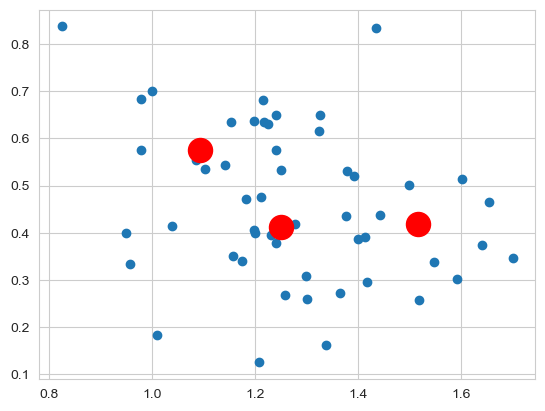

In [66]:
#Centromeros
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(cc)
plt.scatter(cc[:,0], cc[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

Como los datos estan cerca pero no comprimidos, me pareció que es mejor dejar los outliers porque sino menos dispersos estarian los datos, y mas cerca entre si los centromeros, siendo minima la diferencia entre ir a un grupo u otro - No sé si funciona asi, entendí que los centromeros se colocan al azar, pero si los datos estan mas juntos, mas juntos aun los centromeros, asi se quedan un poco mas lejos

Preprocesado y modelado

Porcentaje de varianza explicada por cada componente
[0.56712897 0.30573271 0.12713832]


Text(0, 0.5, 'Por. varianza explicada')

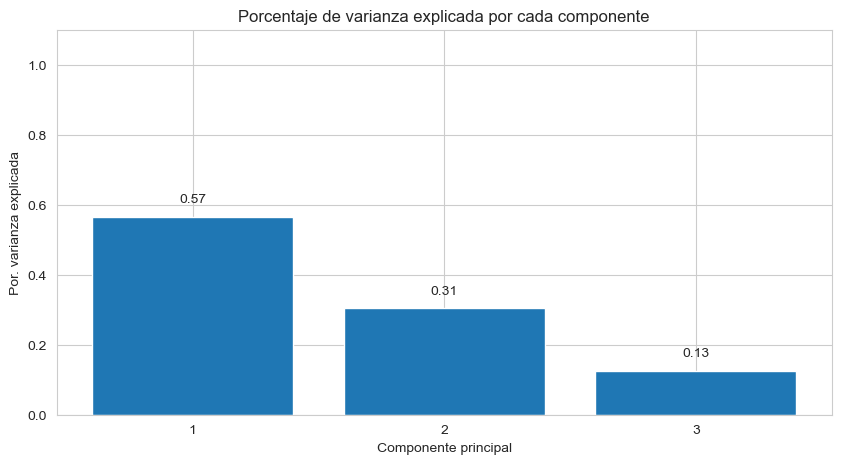

In [67]:
cc =cc1
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(cc)
# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
# Porcentaje de varianza explicada por cada componente
print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)
import seaborn as sns;sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(x= np.arange(modelo_pca.n_components_) + 1,height = modelo_pca.explained_variance_ratio_)
for x, y in zip(np.arange(len(cc.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1);ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')

In [68]:
#Graficar clusters

modelcc = model.fit(cc)
labels = modelcc.labels_

cc1['cluster_label'] = labels

#representamos puntos y centroides
# Obtener los Centroides
centroids = modelcc.cluster_centers_

centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

cc1.set_index(c_index, inplace=True)
#print(cc1.sort_values("cluster_label"))
maskcc0 = (cc1['cluster_label'] == 0)
maskcc1 = (cc1['cluster_label'] == 1)
maskcc2 = (cc1['cluster_label'] == 2)


cluster_stats_pxg= cc1.groupby('cluster_label')['pxg'].describe()
print(round(cluster_stats_pxg,2))
cluster_stats_nfxg = cc1.groupby('cluster_label')['nfxg'].describe()
print(round(cluster_stats_nfxg,2))
cluster_stats_rem = cc1.groupby('cluster_label')['rem'].describe()
print(round(cluster_stats_rem,2))




#colores
fondo = "#313332"
verde_lindo = "#46f892"
verde_claro = "#b5fdcd"
scattermedia ="#42424d" #alpha=0.9
text_color = "w"
color_set1 = '#3ff294' # gran verde
color_set2 = '#f4aa51' # amarillo arena naranja
celeste = "#31acce" 
celeste_claro = "#c1e6f0"


# Obtén las coordenadas de los puntos
x = cc1['pxg']
y = cc1['rem']
names = c_index  # Nombres de los puntos

               count  mean   std   min   25%   50%   75%   max
cluster_label                                                 
0               13.0  1.52  0.13  1.24  1.43  1.52  1.60  1.70
1               24.0  1.25  0.11  0.96  1.21  1.25  1.33  1.40
2               15.0  1.09  0.13  0.82  0.99  1.10  1.18  1.32
               count  mean   std   min   25%   50%   75%   max
cluster_label                                                 
0               13.0  0.42  0.15  0.26  0.34  0.38  0.47  0.83
1               24.0  0.41  0.16  0.12  0.30  0.40  0.53  0.65
2               15.0  0.58  0.13  0.34  0.50  0.57  0.67  0.84
               count  mean   std   min   25%   50%   75%   max
cluster_label                                                 
0               13.0  0.73  0.15  0.49  0.62  0.71  0.77  1.01
1               24.0  0.45  0.11  0.12  0.43  0.47  0.51  0.66
2               15.0  0.23  0.12  0.04  0.16  0.20  0.33  0.42


In [70]:
cc1.head()

,pxg,nfxg,rem,cluster_label
name,,,,
Dalbianco,1.700000,0.346970,0.709848,0
Paquito,1.653968,0.465079,0.649206,0
Tolito,1.641667,0.375000,0.486667,0
Stupa,1.602236,0.513821,0.718089,0
Coello,1.592901,0.302469,0.765586,0


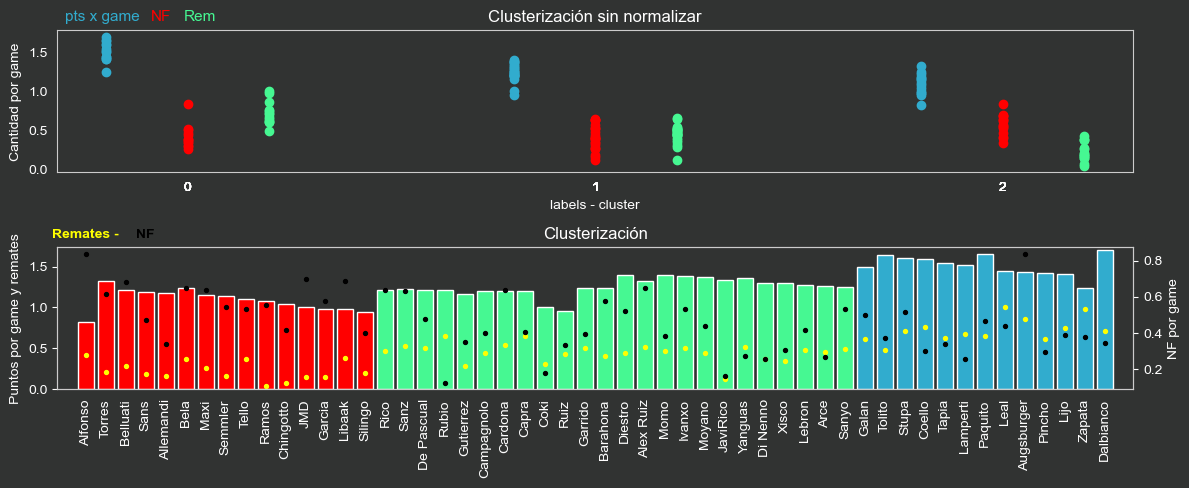

In [71]:
def g_bar(df):
    # Crea el gráfico scatter con nombres
    df= df.sort_values("cluster_label", ascending=False)
    
    fig, axs = plt.subplots(2,1,figsize=(12,5))
    fig.set_facecolor(fondo)
    name1 = "pts x game"
    name2 = "NF"
    name3 = "Rem"
    
    ax=axs[0]
    width = 0.2
    index = np.arange(3)
    
    
    ax.patch.set_facecolor(fondo)
    ax.scatter(df["cluster_label"] , "pxg", data=df,label='pts por game',color=celeste)
    ax.scatter(df["cluster_label"] + width, "nfxg", data=df,label = "NF",color="red")
    ax.scatter(df["cluster_label"] + width *2, "rem", data=df,label="Remate",color=verde_lindo)
    ax.set_ylabel("Cantidad por game", color="w")
    ax.set_xlabel("labels - cluster",color="w")
    ax.set_xticks(labelsx + width, labels)
    plt.margins(0.02)
    ax.text(-0.1,1.9,name1, color=celeste, fontsize=11)
    ax.text(0.11,1.9,name2, color="red", fontsize=11)
    ax.text(0.19,1.9,name3, color=verde_lindo, fontsize=11)

    ax.tick_params(axis="y", colors = "w")
    ax.tick_params(axis="x", colors = "w")
    ax.set_title("Clusterización sin normalizar", color ="w")
    ax.xaxis.grid(False)  # Desactivar las líneas de la cuadrícula en el eje x
    ax.yaxis.grid(False)
    ax.grid(False)
    
    
    ax=axs[1]
    
    ax.patch.set_facecolor(fondo)
    #sns.barplot(x= df.index, y=df["rem"], hue=df["cluster_label"])
    # Define una paleta de colores personalizada
    colores = [celeste, verde_lindo, "red"]

    # Asigna colores a las barras en función de los valores de "cluster_label"
    colores_barras = [colores[label] for label in df["cluster_label"]]
    ax.bar(df.index, df["pxg"], color=colores_barras)
    ax.scatter(df.index, df["rem"], color ="yellow", s=8)
    plt.xticks(rotation=90)
    ax.set_ylabel("Puntos por game y remates", color = "w")
    ax2 = ax.twinx()
    ax2.scatter(df.index, df["nfxg"], color ="black",s=8)
    ax2.set_ylabel("NF por game", color = "w")

    #cambiar colores
    ax.tick_params(axis="y", colors="white")
    ax2.tick_params(axis="y", colors="white")
    ax.tick_params(axis="x", colors="white")
   
    
    plt.title("Clusterización", color="w")
    ax.xaxis.grid(False)  # Desactivar las líneas de la cuadrícula en el eje x
    ax.yaxis.grid(False)
    ax.grid(False)
    ax2.grid(False)
    ax.text(0.1, 1.85, "Remates - ", color="yellow", weight='bold', ha='center')
    ax.text(3, 1.85, "NF", color="black", weight='bold', ha='center')
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
g_bar(cc1)

El PCA mostró la columna puntos por game como la que mejor explica al modelo - 56%. Esto concuerda con la division de roles de una pareja, en la cual si hay un jugador que hace pocos puntos se junta con uno que haga muchos puntos. Y, en el medio, hay jugadores que son mas hibridos, los cuales tienen un rendimiento variado en cuanto a los puntos por game y los errores no forzados que cometen. Al agregar los remates, se puede ver que tambien esta columna podria dividir en los mismos cluster a los jugadores, a pesar de que en el PCA explica el 13% de la varianza. Esto deja a entrever que los jugadores que mas puntos hacen aprovechan la via del remate para hacerlos

Hoy en dia, la pareja rankeada 4ta, tiene 2 jugadores del cluster verde, siendo uno de ellos el que mas puntos hace por game en el cluster y con pocos errores no forzados - Momo. En cambio su pareja tiene rendimientos mas variados, sobretodo en lo que respecta a errores no forzados - Sanyo.





Análisis del ranking

La pareja rankeada 1era, es la que mas se ajusta a la estadística ya que son 2 jugadores que ambos estan por encima del percentilo 85 en puntos por game, única pareja que tiene a 2 jugadores con tantos puntos, y ademas son la pareja que menos errores no forzados comete. Hacen muchos puntos y otorgan pocos al rival. Como detalle no menor, tambien son los que mas rematan, teniendo una de las efectividades mas altas además. Se encuentran invictos.

La numero 2: tienen un jugador del grupo de los ofensivos y el otro es un hibrido, que tiene partidos en los cuales se vuelve mas ofensivo y tiene menos errores no forzados que su compañero

La numero 3: tienen un jugador del grupo de los ofensivos y el otro es un hibrido, que tiene partidos en los cuales se vuelve mas defensivo y es de los que menos errores no forzados tiene en el torneo

La numero 4: tiene 2 jugadores hibridos, siendo uno de ellos el que mas puntos hace por game en el cluster y con pocos errores no forzados. En cambio, su pareja, tiene rendimientos mas variados, sobretodo en lo que respecta a errores no forzados.

La numero 5: tiene el jugador que mas puntos hace en el torneo por games y a un jugador del cluster defensivo, quien hace pocos puntos (los termina haciendo su compañero) y comete muy pocos errores no forzados

Esto denota que no hay una formula única en el armado de jugadores con respecto a los roles de cada uno

En cuanto a las malas combinaciones: es una tentación juntar 2 jugadores que hagan muchos puntos por game, sin embargo, estos jugadores suelen estar por encima del percentilo 50 en errores no forzados, y juntar a jugadores que "compitan" por hacer puntos y se "hundan" por los errores no forzados no ha tenido buenos resultados, excepto los actuales numero 1, pero ellos comenten muy pocos errores no forzados ambos

Ya tengo un modelo de aprendisaje supervisado que predice quién gana y quién pierde. La idea seria agregar esa informacion para mezclar a los jugadores y ver cuáles son buenas combinaciones y cuáles podrian serlo